Saving z6330970817984_882a99088b8e0cb1831d54998e30e525.jpg to z6330970817984_882a99088b8e0cb1831d54998e30e525 (9).jpg


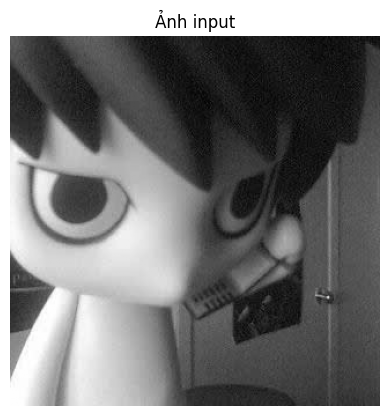

Nhấn phím [I - G - L - H - C]: I


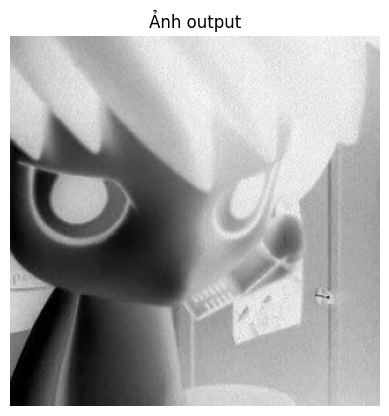

In [20]:
# BÀI TẬP 1

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

uploaded = files.upload()
filename = list(uploaded.keys())[0]
img = Image.open(filename).convert('L')

plt.imshow(img, cmap='gray')
plt.title('Ảnh input')
plt.axis('off')
plt.show()

key = input("Nhấn phím [I - G - L - H - C]: ").upper()

if key == 'I':
    im = np.asarray(img)
    new_img = Image.fromarray(255 - im)

elif key == 'G':
    gamma = 0.5
    im = np.asarray(img).astype(float)
    im = np.power(im / np.max(im), gamma) * 255
    new_img = Image.fromarray(np.clip(im, 0, 255).astype(np.uint8))

elif key == 'L':
    im = np.asarray(img).astype(float)
    im = (128 * np.log(1 + im)) / np.log(1 + np.max(im))
    new_img = Image.fromarray(im.astype(np.uint8))

elif key == 'H':
    im = np.asarray(img)
    flat = im.flatten()
    hist, _ = np.histogram(im, 256, [0, 255])
    cdf = hist.cumsum()
    cdf = np.ma.masked_equal(cdf, 0)
    cdf = ((cdf - cdf.min()) * 255) / (cdf.max() - cdf.min())
    cdf = np.ma.filled(cdf, 0).astype('uint8')
    im2 = cdf[flat].reshape(im.shape)
    new_img = Image.fromarray(im2)

elif key == 'C':
    im = np.asarray(img).astype(float)
    im = 255 * (im - im.min()) / (im.max() - im.min())
    new_img = Image.fromarray(im.astype(np.uint8))

else:
    print("Phím không hợp lệ!")
    new_img = None

if new_img:
    plt.imshow(new_img, cmap='gray')
    plt.title('Ảnh output')
    plt.axis('off')
    plt.show()


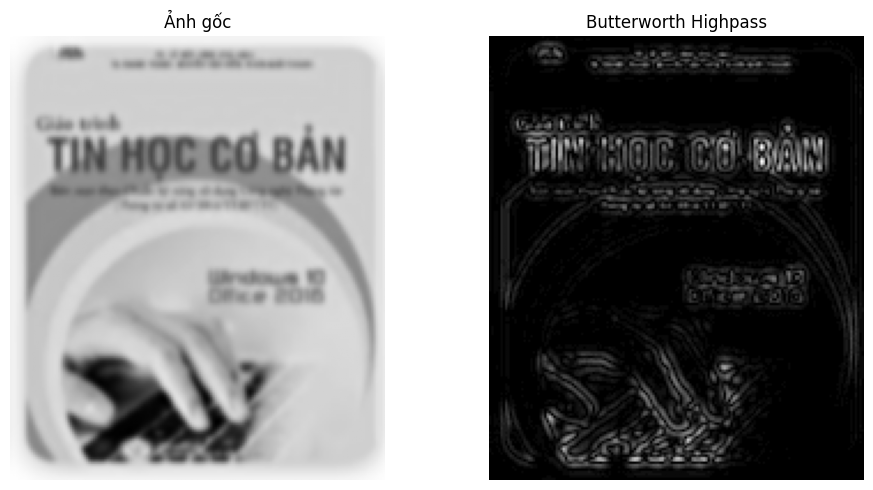

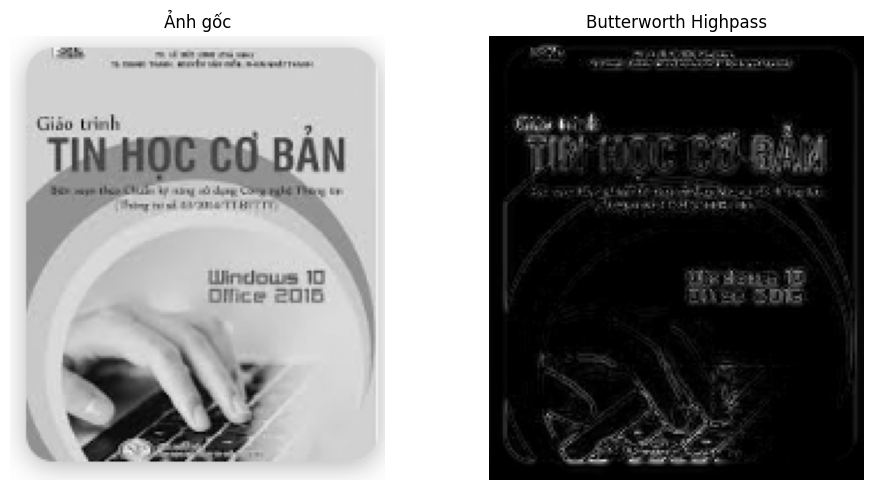

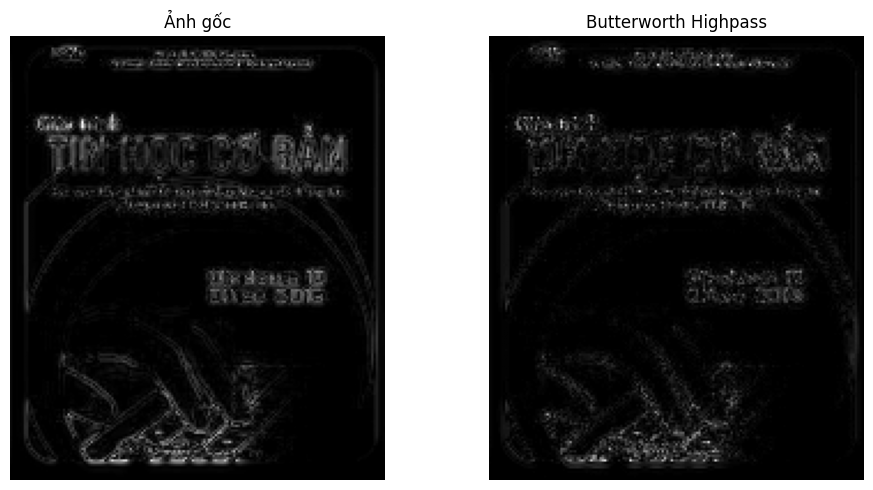

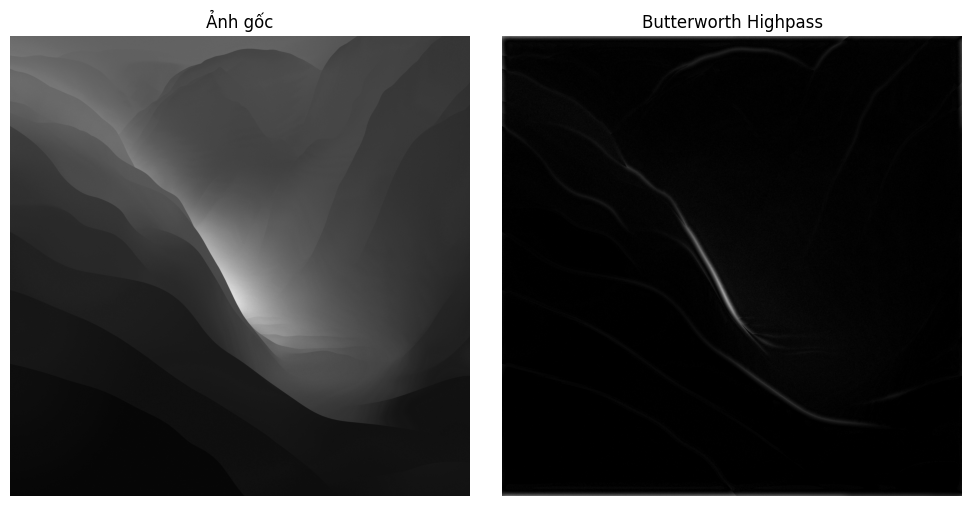

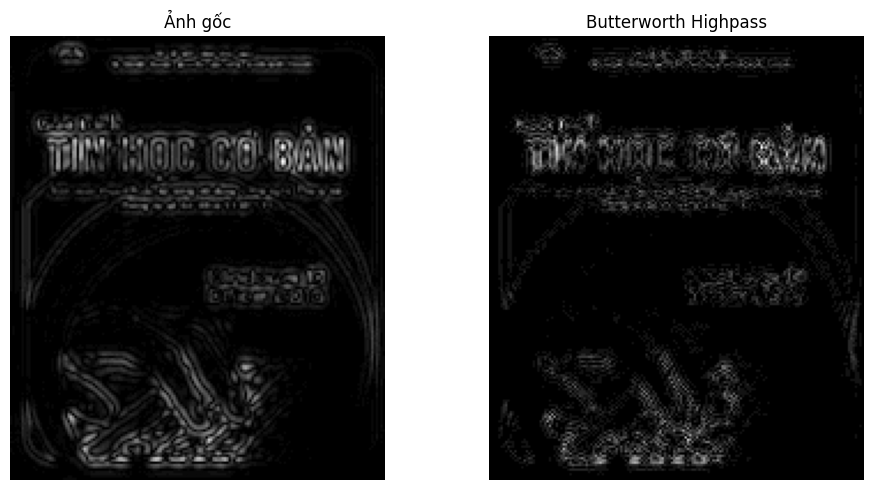

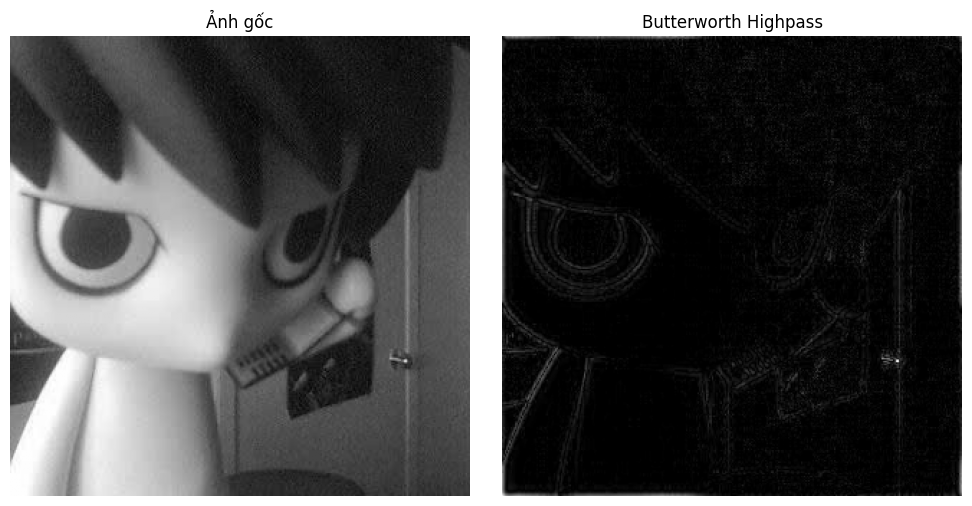

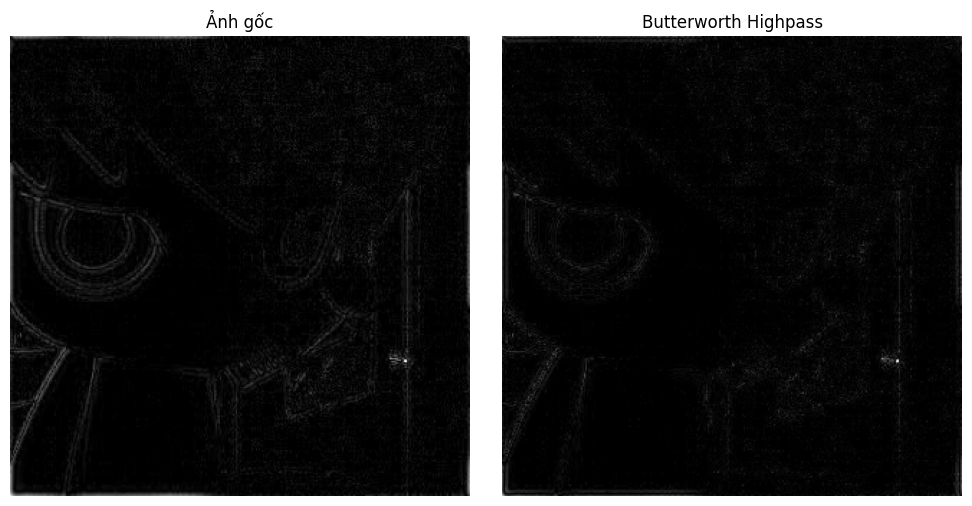

In [21]:
# BÀI TẬP 2
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import files
from IPython.display import clear_output

os.makedirs("exercise", exist_ok=True)

print("upload ảnh cần xử lý:")
uploaded = files.upload()

# Lưu vào thư mục "exercise"
for name in uploaded.keys():
    with open(os.path.join("exercise", name), 'wb') as f:
        f.write(uploaded[name])

# Fourier
def fast_fourier_transform(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # chuyển ảnh sang xám
    f = np.fft.fft2(gray)                         # biến đổi Fourier 2D
    fshift = np.fft.fftshift(f)                   # chuyển tâm phổ ra giữa
    magnitude = 20 * np.log(np.abs(fshift) + 1)   # tính biên độ
    return magnitude

# Butterworth (lowpass/highpass)
def butterworth_filter(img, cutoff, order, lowpass=True):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # chuyển ảnh sang xám
    rows, cols = gray.shape
    crow, ccol = rows // 2, cols // 2              # lấy tọa độ tâm ảnh

    dft = np.fft.fft2(gray)
    dft_shift = np.fft.fftshift(dft)

    # tạo mặt nạ lọc với meshgrid đúng chiều
    u = np.arange(rows)
    v = np.arange(cols)
    u, v = np.meshgrid(u - crow, v - ccol, indexing='ij')

    D = np.sqrt(u**2 + v**2)
    H = 1 / (1 + (D / cutoff)**(2 * order))  # ct lọc

    if not lowpass:
        H = 1 - H  # chuyển sang highpass

    filtered = dft_shift * H
    f_ishift = np.fft.ifftshift(filtered)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    return img_back.astype(np.uint8)

# Hàm xla theo lựa chọn
def process_images(mode):
    for file in os.listdir("exercise"):
        path = os.path.join("exercise", file)
        img = cv2.imread(path)

        if img is None:
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        if mode == 'F':
            output = fast_fourier_transform(img)
            out_name = "FFT_" + file
            title = "Fourier Transform"
            plt.imsave(os.path.join("exercise", out_name), output, cmap='gray')

        elif mode == 'L':
            output = butterworth_filter(img, cutoff=30, order=2, lowpass=True)
            out_name = "Lowpass_" + file
            title = "Butterworth Lowpass"
            cv2.imwrite(os.path.join("exercise", out_name), output)

        elif mode == 'H':
            output = butterworth_filter(img, cutoff=30, order=2, lowpass=False)
            out_name = "Highpass_" + file
            title = "Butterworth Highpass"
            cv2.imwrite(os.path.join("exercise", out_name), output)

        else:
            print("Phím ko hợp lệ!")
            return

        # Show in và out
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(gray, cmap='gray')
        axs[0].set_title("Ảnh gốc")
        axs[0].axis('off')

        axs[1].imshow(output, cmap='gray')
        axs[1].set_title(title)
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()
print("CHỌN PP XỬ LÝ ẢNH:")
print("F - Fast Fourier Transform")
print("L - Butterworth Lowpass Filter")
print("H - Butterworth Highpass Filter")
key = input("Nhập lựa chọn (F/L/H): ").strip().upper()
clear_output()

process_images(key)
